<a href="https://colab.research.google.com/github/vivekdarji-git/public/blob/master/RNN_Tensorflow_Keras_Movie_Sentiment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [6]:
#setup inputs
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDJ720N/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDJ720N/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDJ720N/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [7]:
print("done")

done


In [8]:
encoder = info.features['text'].encoder
encoder.vocab_size

8185

In [9]:
sample_string = "Hi this is encoder"
encoded_string = encoder.encode(sample_string)
encoded_string

[1052, 7961, 14, 9, 6213, 1480]

In [10]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

1052 ----> Hi
7961 ---->  
14 ----> this 
9 ----> is 
6213 ----> enco
1480 ----> der


In [11]:
#Prepare the data for training
buffer_size = 10000
batch_size = 64

train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.padded_batch(batch_size)

test_dataset = test_dataset.padded_batch(batch_size)

In [12]:
#creating a model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

In [13]:
#train the model

history = model.fit(train_dataset, epochs = 10, validation_data = test_dataset, validation_steps = 30)

Epoch 1/10
391/391 [==============================] - 46s 116ms/step - loss: 0.6630 - accuracy: 0.5342 - val_loss: 0.4989 - val_accuracy: 0.7901
Epoch 2/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3579 - accuracy: 0.8513 - val_loss: 0.3415 - val_accuracy: 0.8542
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.2574 - accuracy: 0.9007 - val_loss: 0.3286 - val_accuracy: 0.8620
Epoch 4/10
391/391 [==============================] - 45s 115ms/step - loss: 0.2163 - accuracy: 0.9193 - val_loss: 0.3872 - val_accuracy: 0.8698
Epoch 5/10
391/391 [==============================] - 45s 116ms/step - loss: 0.1858 - accuracy: 0.9342 - val_loss: 0.3368 - val_accuracy: 0.8729
Epoch 6/10
391/391 [==============================] - 45s 116ms/step - loss: 0.1696 - accuracy: 0.9389 - val_loss: 0.3668 - val_accuracy: 0.8698
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.1477 - accuracy: 0.9490 - val_loss: 0.3515 - val_ac

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)
print("test loss: ", test_loss)
print("test accuarcy: ", test_acc)

391/391 [==============================] - 20s 51ms/step - loss: 0.4251 - accuracy: 0.8550
test loss:  0.4250968396663666
test accuarcy:  0.854960024356842


If the prediction is >= 0.5, it is positive else it is negative.

In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text,0))

  return (predictions)

In [47]:
# predict on a sample text with padding

sample_pred_text = ('This movie was actually funny and witty.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[2.478837]]


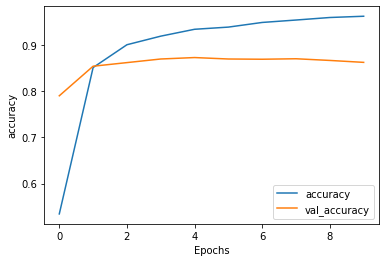

In [25]:
plot_graphs(history, 'accuracy')

In [30]:
#more lstm with dropout


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
________________________________________________

In [50]:
history = model.fit(train_dataset, epochs=50,
                    validation_data=test_dataset,
                    validation_steps=30)


test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

sample_pred_text = ('The movie was good, funny and witty. I would recommend')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

Epoch 1/50
391/391 [==============================] - 79s 201ms/step - loss: 0.1717 - accuracy: 0.9372 - val_loss: 0.3508 - val_accuracy: 0.8698
Epoch 2/50
391/391 [==============================] - 79s 202ms/step - loss: 0.1283 - accuracy: 0.9566 - val_loss: 0.3905 - val_accuracy: 0.8677
Epoch 3/50
391/391 [==============================] - 79s 201ms/step - loss: 0.0921 - accuracy: 0.9700 - val_loss: 0.4061 - val_accuracy: 0.8661
Epoch 4/50
391/391 [==============================] - 78s 201ms/step - loss: 0.0671 - accuracy: 0.9800 - val_loss: 0.4626 - val_accuracy: 0.8651
Epoch 5/50
391/391 [==============================] - 79s 202ms/step - loss: 0.0550 - accuracy: 0.9842 - val_loss: 0.5631 - val_accuracy: 0.8698
Epoch 6/50
391/391 [==============================] - 78s 199ms/step - loss: 0.0425 - accuracy: 0.9889 - val_loss: 0.5824 - val_accuracy: 0.8651
Epoch 7/50
391/391 [==============================] - 78s 200ms/step - loss: 0.0400 - accuracy: 0.9898 - val_loss: 0.6295 - val_ac

[[2.2296693]]


In [1]:
tfds.as_numpy(dataset)

NameError: ignored